# Seq2Seq Translation with LSTM  
### English to French Machine Translation

### Authors:
* Huỳnh Anh Nhựt
* Nguyễn Tiến Minh

**Bao gồm:**
- Chuẩn bị dữ liệu (raw → processed)
- Encoder–Decoder LSTM
- Training loop (teacher forcing)
- Inference (translate function)
- Evaluation (BLEU score)
- 5 ví dụ dịch + phân tích lỗi

---

### Import thư viện 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
import random
from processed_data import (en_tokenizer, fr_tokenizer,build_vocab, load_parallel, ParallelDataset, make_collate_fn, encode_sentence_en, encode_sentence_fr, save_vocab, load_vocab, save_dataset_pytorch, load_dataset_pytorch)

# 1. Load dataset

### Tạo dataset mới từ raw

In [7]:
# train_pairs = load_parallel('./data/raw/train.en', './data/raw/train.fr')
# val_pairs = load_parallel('./data/raw/val.en', './data/raw/val.fr')
# test_pairs = load_parallel('./data/raw/test_2016_flickr.en', './data/raw/test_2016_flickr.fr')

# vocab_en = build_vocab(train_pairs, lang='en', max_tokens=10000, min_freq=2)
# vocab_fr = build_vocab(train_pairs, lang='fr', max_tokens=10000, min_freq=2)

# save_vocab(vocab_en, './data/processed/vocab_en.pkl')
# save_vocab(vocab_fr, './data/processed/vocab_fr.pkl')

# train_ds = ParallelDataset(train_pairs, vocab_en, vocab_fr)
# val_ds = ParallelDataset(val_pairs, vocab_en, vocab_fr)
# test_ds = ParallelDataset(test_pairs, vocab_en, vocab_fr)

# save_dataset_pytorch(train_ds, './data/processed/train_ds.pt')
# save_dataset_pytorch(val_ds, './data/processed/val_ds.pt')
# save_dataset_pytorch(test_ds, './data/processed/test_ds.pt')

### Load dataset đã qua xử lý

In [2]:
vocab_en = load_vocab('./data/processed/vocab_en.pkl')
vocab_fr = load_vocab('./data/processed/vocab_fr.pkl')

train_ds = load_dataset_pytorch('./data/processed/train_dataset.pt')
valid_ds = load_dataset_pytorch('./data/processed/valid_dataset.pt')
test_ds = load_dataset_pytorch('./data/processed/test_dataset.pt')

collate_fn = make_collate_fn(vocab_en, vocab_fr)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)

# 2. LSTM Model

In [3]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.W_i = nn.Linear(input_size, hidden_size, bias=True)
        self.U_i = nn.Linear(hidden_size, hidden_size, bias=True)
        self.W_f = nn.Linear(input_size, hidden_size, bias=True)
        self.U_f = nn.Linear(hidden_size, hidden_size, bias=True)
        self.W_o = nn.Linear(input_size, hidden_size, bias=True)
        self.U_o = nn.Linear(hidden_size, hidden_size, bias=True)
        self.W_c = nn.Linear(input_size, hidden_size, bias=True)
        self.U_c = nn.Linear(hidden_size, hidden_size,  bias=True)

    def forward(self, x, h_prev, c_prev):
        i_t = torch.sigmoid(self.W_i(x) + self.U_i(h_prev))
        f_t = torch.sigmoid(self.W_f(x) + self.U_f(h_prev))
        o_t = torch.sigmoid(self.W_o(x) + self.U_o(h_prev))
        c_tilde_t = torch.tanh(self.W_c(x) + self.U_c(h_prev))
        c_t = f_t * c_prev + i_t * c_tilde_t
        h_t = o_t * torch.tanh(c_t)
        return h_t, c_t

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cells = nn.ModuleList([LSTMCell(input_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)])

    def forward(self, x, h_0=None, c_0=None):
        batch_size, seq_len, _ = x.size()
        if h_0 is None:
            h_0 = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        if c_0 is None:
            c_0 = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]

        h_n = []
        c_n = []
        outputs = []

        for t in range(seq_len):
            x_t = x[:, t, :]
            for layer in range(self.num_layers):
                h_prev = h_0[layer]
                c_prev = c_0[layer]
                h_t, c_t = self.cells[layer](x_t, h_prev, c_prev)
                h_0[layer] = h_t
                c_0[layer] = c_t
                x_t = h_t
            outputs.append(h_t.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)
        h_n = h_0
        c_n = c_0

        return outputs, (h_n, c_n)

class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, num_layers=2):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embed_size)
        self.lstm = LSTM(embed_size, hidden_size, num_layers)
        self.hidden_size = hidden_size
    
    def forward(self, x):
        embedded = self.embedding(x)
        outputs, (h_n, c_n) = self.lstm(embedded)
        return outputs, (h_n, c_n)

class Decoder(nn.Module):
    def __init__(self, output_size, embed_size, hidden_size, num_layers=2):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_size, embed_size)
        self.lstm = LSTM(embed_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x, h_0, c_0):
        embedded = self.embedding(x)
        outputs, (h_n, c_n) = self.lstm(embedded, h_0, c_0)
        logits = self.fc(outputs)
        return logits, (h_n, c_n)
    
    def forward_step(self, y_prev, h, c):
        # y_prev: (batch,)
        y_prev = y_prev.unsqueeze(1)         # (batch, 1)
        embedded = self.embedding(y_prev)    # (batch, 1, embed)
        
        outputs, (h, c) = self.lstm(embedded, h, c)
        logits = self.fc(outputs[:, -1, :])  # lấy token cuối

        return logits, h, c
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, sos_id, eos_id):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sos_id = sos_id
        self.eos_id = eos_id
    
    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size, tgt_len = tgt.size()
        vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, tgt_len, vocab_size, device=src.device)

        # encoder produce h, c
        encoder_outputs, (h, c) = self.encoder(src)

        # start token
        y_prev = torch.full((batch_size,), self.sos_id, device=src.device)

        for t in range(tgt_len):
            probs, h, c = self.decoder.forward_step(y_prev, h, c)
            outputs[:, t, :] = probs

            # teacher forcing
            use_tf = torch.rand(1).item() < teacher_forcing_ratio
            y_prev = tgt[:, t] if use_tf else probs.argmax(dim=-1)

        return outputs



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Sử dụng GPU để train mô hình LSTM

encoder = Encoder(input_size=len(vocab_en), embed_size=256, hidden_size=512, num_layers=2)
decoder = Decoder(output_size=len(vocab_fr), embed_size=256, hidden_size=512, num_layers=2)
seq2seq_model = Seq2Seq(encoder, decoder, sos_id=vocab_fr['<sos>'], eos_id=vocab_fr['<eos>']).to(device)

# 3. Model Training

In [5]:
pad_idx = vocab_fr.stoi['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = torch.optim.Adam(seq2seq_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=1, factor=0.5
)


In [6]:
train_losses = []
val_losses = []

def train_model(model, train_loader, valid_loader, num_epochs=20, teacher_forcing_ratio=0.5):
    best_val_loss = float("inf")
    patience = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for src, tgt, src_lens, tgt_lens in train_loader:
            src = src.to(device)
            tgt = tgt.to(device)

            optimizer.zero_grad()

            outputs = model(src, tgt, teacher_forcing_ratio)
            outputs = outputs[:, :-1, :].reshape(-1, outputs.size(-1))
            tgt_gold = tgt[:, 1:].reshape(-1)

            loss = criterion(outputs, tgt_gold)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for src, tgt, _, _ in valid_loader:
                src = src.to(device)
                tgt = tgt.to(device)

                outputs = model(src, tgt, 0)
                outputs = outputs[:, :-1, :].reshape(-1, outputs.size(-1))
                tgt_gold = tgt[:, 1:].reshape(-1)

                loss = criterion(outputs, tgt_gold)
                val_loss += loss.item()

        # Averages
        avg_train = train_loss / len(train_loader)
        avg_val   = val_loss / len(valid_loader)

        scheduler.step(avg_val)

        print(f"Epoch {epoch+1} | Train: {avg_train:.4f} | Val: {avg_val:.4f}")

        train_losses.append(avg_train)
        val_losses.append(avg_val)

        # Save best model
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            patience = 0
            torch.save(model.state_dict(), "best_model.pt")
            print("  → Saved best model")
        else:
            patience += 1
            if patience >= 3:
                print("Early stopping triggered!")
                break


In [7]:
train_model(seq2seq_model, train_loader, valid_loader, num_epochs=20, teacher_forcing_ratio=0.5)



Epoch 1 | Train: 4.9088 | Val: 4.5709
  → Saved best model
Epoch 2 | Train: 4.0873 | Val: 4.1153
  → Saved best model
Epoch 3 | Train: 3.6466 | Val: 3.8161
  → Saved best model
Epoch 4 | Train: 3.3158 | Val: 3.6336
  → Saved best model
Epoch 5 | Train: 3.0454 | Val: 3.4987
  → Saved best model
Epoch 6 | Train: 2.8131 | Val: 3.3908
  → Saved best model
Epoch 7 | Train: 2.6070 | Val: 3.3070
  → Saved best model
Epoch 8 | Train: 2.4255 | Val: 3.2592
  → Saved best model
Epoch 9 | Train: 2.2414 | Val: 3.2524
  → Saved best model
Epoch 10 | Train: 2.0783 | Val: 3.2231
  → Saved best model
Epoch 11 | Train: 1.9181 | Val: 3.2822
Epoch 12 | Train: 1.7867 | Val: 3.2692
Epoch 13 | Train: 1.5475 | Val: 3.2788
Early stopping triggered!


## Biểu đồ Loss


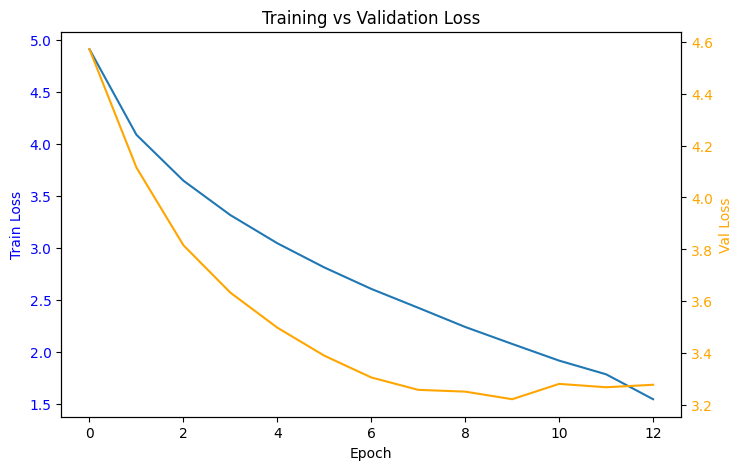

In [8]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    epochs = list(range(len(train_losses)))

    fig, ax1 = plt.subplots(figsize=(8, 5))

    ax1.plot(epochs, train_losses, label="Train Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Train Loss", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()
    ax2.plot(epochs, val_losses, label="Val Loss", color="orange")
    ax2.set_ylabel("Val Loss", color="orange")
    ax2.tick_params(axis='y', labelcolor="orange")

    plt.title("Training vs Validation Loss")
    plt.show()

plot_losses(train_losses, val_losses)

# 4. Dịch tập test

In [ ]:
def translate(sentence, model, vocab_en, vocab_fr, max_len=50):
    model.eval()

    # tokenize
    tokens = list(en_tokenizer(sentence))
    ids = [vocab_en.stoi.get(tok, vocab_en.stoi["<unk>"]) for tok in tokens]
    src = torch.tensor(ids).unsqueeze(0).to(next(model.parameters()).device)

    # encode
    _, (h, c) = model.encoder(src)

    # decode từng bước
    y_prev = torch.tensor([vocab_fr.stoi["<sos>"]], device=src.device)
    result_ids = []

    for _ in range(max_len):
        probs, h, c = model.decoder.forward_step(y_prev, h, c)
        y_prev = probs.argmax(dim=-1)

        token_id = y_prev.item()
        if token_id == vocab_fr.stoi["<eos>"]:
            break
        
        result_ids.append(token_id)

    # convert id -> word bằng vocab_fr.itos
    words = [vocab_fr.itos[i] for i in result_ids]
    return " ".join(words)

In [10]:
def decode_tensor(tensor_ids, vocab):
    # vocab.itos là list: index -> token
    tokens = []
    for idx in tensor_ids.tolist():
        if idx < len(vocab.itos):
            tokens.append(vocab.itos[idx])
    # bỏ pad/sos/eos
    tokens = [t for t in tokens if t not in ["<pad>", "<sos>", "<eos>"]]
    return " ".join(tokens)

def show_examples(test_ds, model, vocab_en, vocab_fr, n=5):
    print("------ TRANSLATE ------")
    for i in range(n):
        src_tensor, tgt_tensor = test_ds[i]

        eng = decode_tensor(src_tensor, vocab_en)
        fr  = decode_tensor(tgt_tensor, vocab_fr)
        pred = translate(eng, model, vocab_en, vocab_fr)
        print(f"\n[Example {i+1}]")
        print(f"EN:   {eng}")
        print(f"FR:   {fr}")
        print(f"PRED: {pred}")


# 5. Đánh giá mô hình

In [11]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torch

def compute_bleu(model, test_ds, vocab_en, vocab_fr, max_samples=500):
    model.eval()
    smoothie = SmoothingFunction().method1

    inv_fr = {i: tok for tok, i in vocab_fr.stoi.items()}

    def tensor_to_sentence(tensor_ids):
        words = []
        for idx in tensor_ids:
            token = inv_fr.get(idx.item(), "<unk>")
            if token in ["<sos>", "<pad>"]:
                continue
            if token == "<eos>":
                break
            words.append(token)
        return words

    total_bleu = 0
    count = min(max_samples, len(test_ds))

    for i in range(count):
        src_tensor, tgt_tensor = test_ds[i]

        # convert tgt_tensor → list token words
        tgt_tokens = tensor_to_sentence(tgt_tensor)

        # translate predicted
        inv_en = {i: tok for tok, i in vocab_en.stoi.items()}

        src_words = []
        for tok in src_tensor:
            word = inv_en.get(tok.item(), "<unk>")
            if word in ["<pad>", "<sos>", "<eos>"]:
                continue
            src_words.append(word)

        src_sentence = " ".join(src_words)

        pred_text = translate(src_sentence, model, vocab_en, vocab_fr)

        pred_tokens = pred_text.split()

        # compute BLEU (unigram + bigram)
        bleu = sentence_bleu(
            [tgt_tokens], pred_tokens,
            smoothing_function=smoothie,
            weights=(0.5, 0.5, 0, 0)
        )
        total_bleu += bleu

    bleu_score = total_bleu / count
    print(f"\nBLEU score = {bleu_score:.4f} on {count} samples")
    return bleu_score


In [20]:
seq2seq_model.load_state_dict(torch.load("best_model.pt", map_location=device))
seq2seq_model.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6191, 256)
    (lstm): LSTM(
      (cells): ModuleList(
        (0): LSTMCell(
          (W_i): Linear(in_features=256, out_features=512, bias=True)
          (U_i): Linear(in_features=512, out_features=512, bias=True)
          (W_f): Linear(in_features=256, out_features=512, bias=True)
          (U_f): Linear(in_features=512, out_features=512, bias=True)
          (W_o): Linear(in_features=256, out_features=512, bias=True)
          (U_o): Linear(in_features=512, out_features=512, bias=True)
          (W_c): Linear(in_features=256, out_features=512, bias=True)
          (U_c): Linear(in_features=512, out_features=512, bias=True)
        )
        (1): LSTMCell(
          (W_i): Linear(in_features=512, out_features=512, bias=True)
          (U_i): Linear(in_features=512, out_features=512, bias=True)
          (W_f): Linear(in_features=512, out_features=512, bias=True)
          (U_f): Linear(in_features=512, out_features=512, b

In [12]:
bleu = compute_bleu(seq2seq_model, test_ds, vocab_en, vocab_fr, max_samples=5000)



BLEU score = 0.3686 on 1000 samples


In [13]:
show_examples(test_ds, seq2seq_model, vocab_en, vocab_fr, n=5)



------ TRANSLATE ------

[Example 1]
EN:   A man in an orange hat starring at something .
FR:   Un homme avec un chapeau orange regardant quelque chose .
PRED: Un homme avec un orange orange quelque quelque chose

[Example 2]
EN:   A Boston Terrier is running on lush green grass in front of a white fence .
FR:   Un terrier de Boston court sur l' herbe verdoyante devant une clôture blanche .
PRED: Un gardien de baseball est sur sur le , devant devant une verte verte .

[Example 3]
EN:   A girl in karate uniform breaking a stick with a front kick .
FR:   Une fille en tenue de karaté brisant un bâton avec un coup de pied .
PRED: Une fille en tenue de karaté frappant un ballon avec un ballon de .

[Example 4]
EN:   Five people wearing winter jackets and helmets stand in the snow , with <unk> in the background .
FR:   Cinq personnes avec des vestes d' hiver et des casques sont debout dans la neige , avec des <unk> en arrière-plan .
PRED: Cinq personnes avec des casques et des des jaunes son

### **Phân tích lỗi**
* **[Example 1]**<br>
FFR:   Un homme avec un chapeau orange regardant quelque chose .<br>
PRED: Un homme avec un veste orange regarde quelque chose<br>
**Lỗi**: 
<br> - "chapeau"(mũ) → "veste"(áo khoác) mô hình dịch sai ngữ nghĩa &rarr; Lỗi dịch sai ngữ nghĩa<br>
**Nguyên nhân:** 
<br> - Encoder không giữ được thông tin đầy đủ (Vấn đề của LSTM với câu dài).<br>

* **[Example 2]**<br>
FR:   Un terrier de Boston court sur l' herbe verdoyante devant une clôture blanche .<br>
PRED: Un gardien de baseball est sur sur le , devant devant une verte verte .e<br>
<br> - "terrier de Boston" → "gardien de baseball" mô hình không học được các danh từ riêng nên thay thế bằng từ khác &rarr; Lỗi thay thế từ
<br> - " sur sur", "verte verte" &rarr; Lỗi lặp từ
**Nguyên nhân:**
<br> - Không dùng attention cho nên mô hình dễ lặp, dễ đoán bừa, dịch sai
<br> - Huấn luyện chưa đủ lâu, do chỉ được huấn luyện < 20 epoch nên mô hình học chưa đủ 

* **[Example 3]**<br>
FR:   Une fille en tenue de karaté brisant un bâton avec un coup de pied .<br>
PRED: Une fille en tenue de karaté frappant un ballon avec un ballon de .<br>
**Lỗi:**
<br> - “ brisant un bâton avec un coup de pied” → “frappant un ballon avec un ballon de .”: mô hình thay cụm từ bằng cụm quen thuộc hơn → Lỗi thay thế từ.
**Nguyên nhân:**
<br> - Không dùng attention nên mô hình không biết dựa vào token nào → sinh các từ phổ biến, từ sai.

* **[Example 4]**<br>
FR: Cinq personnes avec des vestes d' hiver et des casques sont debout dans la neige , avec des <unk> en arrière-plan .<br>
PRED: Cinq personnes avec des casques et des des jaunes sont debout dans la neige avec ville avec des en en en en .<br>
**Lỗi:**
<br> - Mất thông tin quan trọng: “vestes d’hiver”, “arrière-plan” không xuất hiện → Lỗi mất thông tin.
<br> - “et et des en en” → Lỗi lặp từ.
Nguyên nhân:
<br> - Câu rất dài, nhiều mô tả → LSTM mất ngữ cảnh cuối câu (vấn đề cố hữu của RNN).
<br> - Token <unk> làm mô hình lạc hướng → sinh từ “đệm” vô nghĩa.
<br> - Không có attention khiến thông tin bị suy giảm mạnh trên câu dài.

* **[Example 5]**<br>
FR:   Des gens réparent le toit d' une maison .<br>
PRED:   Des gens utilisent la d' d' une .<br>
**Lỗi:**
<br> - "gens réparent le toit" →  "Des gen utilisent" → Lỗi dịch sai ngữ nghĩa
<br> - Xuất hiện “d' d'” → Lỗi lặp token.
**Nguyên nhân:**
<br> - Không có attention nên decoder dự đoán sai khi thiếu thông tin ngữ cảnh.
<br> - Các từ như “toit”, “réparer” có thể xuất hiện ít trong dữ liệu train.<br>

# Tổng kết lỗi của mô hình Seq2Seq 

Qua phân tích các ví dụ dự đoán, mô hình Seq2Seq sử dụng LSTM cho bài dịch máy Anh–Pháp vẫn gặp một số dạng lỗi phổ biến:

1. **Lỗi mất thông tin (Information Loss)**<br>
Mô hình thường bỏ qua một số cụm quan trọng như danh từ, trạng từ hoặc mệnh đề cuối câu.<br>
→ Nguyên nhân chính là LSTM encoder có độ dài tín hiệu hạn chế; khi câu dài hoặc nhiều mô tả, trạng thái ẩn cuối cùng không giữ đủ toàn bộ thông tin.

2. **Lỗi lặp từ (Repetition Error)** <br>
Xuất hiện các chuỗi như “un un un”, “de de”, “sur sur”.<br>
→ Decoder khi dùng greedy decoding dễ rơi vào vòng lặp vì không có cơ chế focus vào token nguồn, dẫn đến sinh lại các từ có xác suất cao nhất.

3. **Lỗi thay thế từ (Word Substitution)** <br>
Nhiều từ hiếm hoặc danh từ riêng bị thay bằng từ gần nghĩa hoặc từ thông dụng.<br>
→ Do phân bố dữ liệu không đều và mô hình không học được embeddings chất lượng cho từ ít xuất hiện.

4. **Lỗi sai ngữ nghĩa (Semantic Error)** <br>
Nhiều câu bị dịch sai ý.<br>
→ Mô hình gặp khó khi hiểu cấu trúc ngữ nghĩa hoặc không giữ đủ thông tin từ câu nguồn, đặc biệt là động từ hành động.

5. **Lỗi cú pháp (Syntactic Error)** <br>
Một số câu dự đoán thiếu cấu trúc, rối cú pháp (“de des et des des”).<br>
→ Decoder không có thông tin ngữ cảnh đủ mạnh để duy trì cấu trúc câu hợp lý trong tiếng Pháp.

6. **Lỗi do từ hiếm**<br>
Những câu có token unk trong nguồn làm mô hình lạc hướng và sinh ra từ "đệm" vô nghĩa.<br>
→ Do vocabulary giới hạn và tokenizer sinh nhiều từ ngoài từ điển.

## Đề xuất cải tiến mô hình

Dựa trên các lỗi và kết quả BLEU hiện tại, có thể cải thiện mô hình theo các hướng sau:

1. **Thêm Attention (Quan trọng nhất)**<br>
Attention giải quyết trực tiếp các vấn đề chính:<br>
- giúp decoder tập trung vào từng phần của câu nguồn
- tránh mất thông tin ở câu dài
- giảm lặp từ
- cải thiện dịch ngữ nghĩa và cú pháp

2. **Dùng Beam Search thay greedy decoding**<br>
Greedy = chọn từ xác suất cao nhất → dễ lặp, dễ sai.<br>
Beam search (k=3 hoặc 5) cải thiện mạnh chất lượng câu.<br>

3. **Tăng số epoch và điều chỉnh learning rate**<br>
Mô hình early stopping sớm (7–10 epoch) vì LR cao + scheduler.<br>
Nên thử:<br>
- train 30–40 epoch
- LR nhỏ hơn 
- patience lớn hơn (5–7)

4. **Tăng kích thước mô hình**<br>
- tăng embedding_dim (256 → 512)
- tăng hidden_dim (512 → 1024)
- dùng 2–3 lớp LSTM cho encoder & decoder
- LSTM lớn hơn giúp mô hình giữ nhiều ngữ cảnh hơn → dịch tự nhiên hơn.

5. **Cải thiện xử lý token**<br>
- giảm min_freq để bớt sinh từ hiếm
- dùng Byte Pair Encoding (BPE) để tránh từ hiếm
- đảm bảo vocab_en và vocab_fr đồng nhất và không quá nhỏ

# 6. Cải tiến mô hình

## 6.1 Train dataset với BPE

In [5]:
import sentencepiece as spm
from processed_data_bpe import (ParallelBpeDataset, bpe_create_loader, bpe_load_parallel, bpe_save_dataset, bpe_load_dataset)

In [ ]:


# # train cho en:
# spm.SentencePieceTrainer.Train(
#     input='data/raw/train.en',
#     model_prefix='data/processed/spm_en',
#     vocab_size=4000,
#     character_coverage=1.0,
#     model_type='bpe',
#     user_defined_symbols='',
#     pad_id=0,
#     unk_id=1,
#     bos_id=2,
#     eos_id=3,
#     num_threads=8)
# # train cho fr:
# spm.SentencePieceTrainer.Train(
#     input='data/raw/train.fr',
#     model_prefix='data/processed/spm_fr',
#     vocab_size=4000,
#     model_type='bpe',
#     character_coverage=1.0,
#     user_defined_symbols='',
#     pad_id=0,
#     unk_id=1,
#     bos_id=2,
#     eos_id=3,
#     num_threads=8)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/raw/train.en
  input_format: 
  model_prefix: data/processed/spm_en
  model_type: BPE
  vocab_size: 4000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 8
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0


=3540 all=19350 active=995 piece=▁bonnets
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=16 size=3560 all=19334 active=979 piece=▁traîneau
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=16 size=3580 all=19314 active=959 piece=▁intersection
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=15 size=3600 all=19404 active=1049 piece=arri
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=15 min_freq=10
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=15 size=3620 all=19479 active=1075 piece=▁crie
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=15 size=3640 all=19491 active=1087 piece=▁garde
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=15 size=3660 all=19501 active=1097 piece=▁flotte
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=15 size=3680 all=19487 active=1083 piece=▁bonbons
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=15 size=3700 all=19484 active=1080 piece=▁athlètes
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=15 min_freq=10
bpe_model

### Load sp model

In [6]:
sp_en = spm.SentencePieceProcessor()
sp_en.Load("data/processed/spm_en.model")

sp_fr = spm.SentencePieceProcessor()
sp_fr.Load("data/processed/spm_fr.model")

True

### Tạo dataset mới từ raw

In [ ]:
# from processed_data_bpe import (ParallelBpeDataset, bpe_create_loader, bpe_load_parallel, bpe_save_dataset, bpe_load_dataset)

# bpe_train_pairs = bpe_load_parallel('data/raw/train.en', 'data/raw/train.fr')
# bpe_val_pairs = bpe_load_parallel('data/raw/val.en', 'data/raw/val.fr')
# bpe_test_pairs = bpe_load_parallel('data/raw/test_2016_flickr.en', 'data/raw/test_2016_flickr.fr')

# bpe_train_ds = ParallelBpeDataset(bpe_train_pairs, sp_en, sp_fr)
# bpe_val_ds = ParallelBpeDataset(bpe_val_pairs, sp_en, sp_fr)
# bpe_test_ds = ParallelBpeDataset(bpe_test_pairs, sp_en, sp_fr)

# bpe_save_dataset(bpe_train_ds, 'data/processed/bpe_train.ds')
# bpe_save_dataset(bpe_val_ds, 'data/processed/bpe_val.ds')
# bpe_save_dataset(bpe_test_ds, 'data/processed/bpe_test.ds')

### Load dataset đã xử lý

In [7]:
bpe_train_ds = bpe_load_dataset('data/processed/bpe_train.ds')
bpe_val_ds = bpe_load_dataset('data/processed/bpe_val.ds')
bpe_test_ds = bpe_load_dataset('data/processed/bpe_test.ds')

bpe_train_loader = bpe_create_loader(bpe_train_ds, batch=64, shuffle=True, sp_en=sp_en, sp_fr=sp_fr)
bpe_val_loader = bpe_create_loader(bpe_val_ds, batch=64, shuffle=True, sp_en=sp_en, sp_fr=sp_fr)
bpe_test_loader = bpe_create_loader(bpe_test_ds, batch=64, shuffle=True, sp_en=sp_en, sp_fr=sp_fr)

## 6.2 Model với Bahdanau Attention

In [8]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.W1 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W2 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.V  = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, dec_top, enc_outputs, src_lengths=None):
        # dec_top: (B,H)
        # enc_outputs: (B,T,H)
        B, T, H = enc_outputs.size()

        dec_expanded = dec_top.unsqueeze(1).expand(B, T, H)
        score = self.V(torch.tanh(
            self.W1(enc_outputs) + self.W2(dec_expanded)
        )).squeeze(-1)  # (B,T)

        if src_lengths is not None:
            mask = torch.arange(T, device=src_lengths.device).unsqueeze(0) >= src_lengths.unsqueeze(1)
            score = score.masked_fill(mask, -1e9)

        attn_w = F.softmax(score, dim=1)
        context = torch.bmm(attn_w.unsqueeze(1), enc_outputs).squeeze(1)
        return context, attn_w


class AttnDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.attn = BahdanauAttention(hidden_size)
        self.lstm = LSTM(embed_dim + hidden_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward_step(self, y_prev, h, c, enc_outputs, src_lengths=None):
        emb = self.embedding(y_prev).unsqueeze(1)  # (B,1,E)
        dec_top = h[-1]  # (B,H)
        context, attn_w = self.attn(dec_top, enc_outputs, src_lengths)
        x = torch.cat([emb, context.unsqueeze(1)], dim=-1)  # (B,1,E+H)

        outputs, (h, c) = self.lstm(x, h, c)
        logits = self.fc(outputs[:, -1, :])
        return logits, h, c, attn_w


class Seq2SeqAttn(nn.Module):
    def __init__(self, encoder, decoder, sos_id, eos_id, pad_id):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sos_id = sos_id
        self.eos_id = eos_id
        self.pad_id = pad_id

    def forward(self, src, tgt=None, teacher_forcing_ratio=0.5, src_lengths=None, max_len=50):
        enc_outputs, (h, c) = self.encoder(src)
        B = src.size(0)

        if tgt is not None:
            tgt_len = tgt.size(1)
        else:
            tgt_len = max_len

        outputs = torch.zeros(B, tgt_len, self.decoder.fc.out_features, device=src.device)
        y_prev = torch.full((B,), self.sos_id, dtype=torch.long, device=src.device)

        for t in range(tgt_len):
            logits, h, c, attn_w = self.decoder.forward_step(y_prev, h, c, enc_outputs, src_lengths)
            outputs[:, t, :] = logits

            if tgt is not None and random.random() < teacher_forcing_ratio:
                y_prev = tgt[:, t]
            else:
                y_prev = logits.argmax(dim=-1)

        return outputs

    @torch.no_grad()
    def translate(self, src, src_lengths=None, max_len=50):
        enc_outputs, (h, c) = self.encoder(src)
        y_prev = torch.tensor([self.sos_id], device=src.device)
        result = []
        for _ in range(max_len):
            logits, h, c, _ = self.decoder.forward_step(y_prev, h, c, enc_outputs, src_lengths)
            y_prev = logits.argmax(dim=-1)
            token = y_prev.item()
            if token == self.eos_id:
                break
            result.append(token)
        return result


In [9]:
encoder = Encoder(sp_en.GetPieceSize(), embed_size=384, hidden_size=768, num_layers=2)
decoder = AttnDecoder(sp_fr.GetPieceSize(), embed_dim=384, hidden_size=768, num_layers=2)

seq2seq_model_att = Seq2SeqAttn(encoder, decoder, sos_id=sp_en.bos_id(), eos_id=sp_en.eos_id(), pad_id=sp_en.pad_id()).to(device)

### Load best model

In [10]:
seq2seq_model_att.load_state_dict(torch.load('last_attn.pth', map_location=device))
seq2seq_model_att.eval()

Seq2SeqAttn(
  (encoder): Encoder(
    (embedding): Embedding(4000, 384)
    (lstm): LSTM(
      (cells): ModuleList(
        (0): LSTMCell(
          (W_i): Linear(in_features=384, out_features=768, bias=True)
          (U_i): Linear(in_features=768, out_features=768, bias=True)
          (W_f): Linear(in_features=384, out_features=768, bias=True)
          (U_f): Linear(in_features=768, out_features=768, bias=True)
          (W_o): Linear(in_features=384, out_features=768, bias=True)
          (U_o): Linear(in_features=768, out_features=768, bias=True)
          (W_c): Linear(in_features=384, out_features=768, bias=True)
          (U_c): Linear(in_features=768, out_features=768, bias=True)
        )
        (1): LSTMCell(
          (W_i): Linear(in_features=768, out_features=768, bias=True)
          (U_i): Linear(in_features=768, out_features=768, bias=True)
          (W_f): Linear(in_features=768, out_features=768, bias=True)
          (U_f): Linear(in_features=768, out_features=76

## 6.3 Train model

In [10]:
criterion = nn.CrossEntropyLoss(ignore_index=sp_en.pad_id(), label_smoothing=0.1)
optimizer = torch.optim.Adam(seq2seq_model_att.parameters(), lr=3e-4, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True, min_lr=1e-5
)


/home/hanhut/miniconda3/envs/nlp/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
def train_model_att(model, train_loader, valid_loader, optimizer, scheduler, criterion,
                    num_epochs=100, teacher_forcing_start=0.7, teacher_forcing_end=0.1,
                    patience_limit=20):

    best_val_loss = float("inf")
    train_losses, val_losses = [], []
    patience = 0

    model.to(device)

    for epoch in range(num_epochs):

        # ---- Teacher forcing: linear decay ----
        # epoch goes 0 → num_epochs-1, so normalize by (num_epochs-1)
        ratio = teacher_forcing_start - epoch * (teacher_forcing_start - teacher_forcing_end) / (num_epochs - 1)
        ratio = max(ratio, teacher_forcing_end)

        model.train()
        total_train_loss = 0

        for src, tgt, src_lens, tgt_lens in train_loader:
            src, tgt, src_lens = src.to(device), tgt.to(device), src_lens.to(device)

            optimizer.zero_grad()

            outputs = model(src, tgt, ratio, src_lens)

            logits = outputs[:, :-1, :].reshape(-1, outputs.size(-1))
            gold   = tgt[:, 1:].reshape(-1)

            loss = criterion(logits, gold)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_train_loss += loss.item()

        # ------ VALIDATION -------
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt, src_lens, _ in valid_loader:
                src, tgt, src_lens = src.to(device), tgt.to(device), src_lens.to(device)

                outputs = model(src, tgt, 0, src_lens)

                logits = outputs[:, :-1, :].reshape(-1, outputs.size(-1))
                gold   = tgt[:, 1:].reshape(-1)

                loss = criterion(logits, gold)
                total_val_loss += loss.item()

        avg_train = total_train_loss / len(train_loader)
        avg_val   = total_val_loss / len(valid_loader)

        train_losses.append(avg_train)
        val_losses.append(avg_val)

        print(f"Epoch {epoch+1:02d} | TF={ratio:.3f} | Train: {avg_train:.4f} | Val: {avg_val:.4f}")

        # ---- SAVE BEST + EARLY STOP ----
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), "best_attn.pth")
            print(f" → Saved BEST model (lr={optimizer.param_groups[0]['lr']:.6f})\n")
            patience = 0
        else:
            patience += 1
            if patience >= patience_limit:
                print("\nEarly stopping triggered!")
                torch.save(model.state_dict(), "last_attn.pth")
                print(f" → Saved LAST model (lr={optimizer.param_groups[0]['lr']:.6f})\n")
                break

        # ---- Step LR scheduler AFTER checking best ----
        scheduler.step(avg_val)

    return train_losses, val_losses


In [ ]:
train_losses, val_losses = train_model_att(seq2seq_model_att, bpe_train_loader, bpe_val_loader, optimizer, scheduler, criterion)








Epoch 01 | TF=0.700 | Train: 5.7014 | Val: 5.6489
 → Saved BEST model (lr=0.000300)

Epoch 02 | TF=0.694 | Train: 5.0791 | Val: 5.3271
 → Saved BEST model (lr=0.000300)

Epoch 03 | TF=0.688 | Train: 4.7071 | Val: 5.0673
 → Saved BEST model (lr=0.000300)

Epoch 04 | TF=0.682 | Train: 4.4021 | Val: 4.8949
 → Saved BEST model (lr=0.000300)

Epoch 05 | TF=0.676 | Train: 4.1438 | Val: 4.6960
 → Saved BEST model (lr=0.000300)

Epoch 06 | TF=0.670 | Train: 3.9185 | Val: 4.6457
 → Saved BEST model (lr=0.000300)

Epoch 07 | TF=0.664 | Train: 3.7328 | Val: 4.5636
 → Saved BEST model (lr=0.000300)

Epoch 08 | TF=0.658 | Train: 3.5706 | Val: 4.4788
 → Saved BEST model (lr=0.000300)

Epoch 09 | TF=0.652 | Train: 3.4163 | Val: 4.3631
 → Saved BEST model (lr=0.000300)

Epoch 10 | TF=0.645 | Train: 3.2761 | Val: 4.3913
Epoch 11 | TF=0.639 | Train: 3.1569 | Val: 4.3670
Epoch 12 | TF=0.633 | Train: 3.0380 | Val: 4.3986
Epoch 13 | TF=0.627 | Train: 2.9315 | Val: 4.3605
 → Saved BEST model (lr=0.000300)



In [20]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    epochs = list(range(len(train_losses)))

    fig, ax1 = plt.subplots(figsize=(8, 5))

    ax1.plot(epochs, train_losses, label="Train Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Train Loss", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()
    ax2.plot(epochs, val_losses, label="Val Loss", color="orange")
    ax2.set_ylabel("Val Loss", color="orange")
    ax2.tick_params(axis='y', labelcolor="orange")

    plt.title("Training vs Validation Loss")
    plt.show()

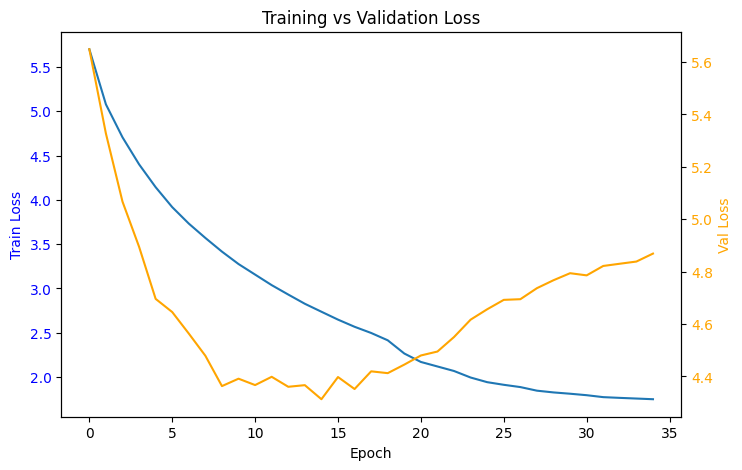

In [21]:
plot_losses(train_losses, val_losses)

## 6.4 Translate với beam search

In [11]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def beam_search_decode(
    model, src_sentence, sp_en, sp_fr,
    beam_size=5, max_len=60, device=None,
    src_lengths=None, alpha=0.7   # ← length penalty
):
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    # ---- Load BOS/EOS from spm ----
    try:
        bos = sp_en.bos_id()
        eos = sp_en.eos_id()
    except:
        bos = sp_en.PieceToId("<s>")
        eos = sp_en.PieceToId("</s>")

    src_ids = [bos] + sp_en.EncodeAsIds(src_sentence) + [eos]
    src = torch.tensor(src_ids, dtype=torch.long, device=device).unsqueeze(0)

    enc_outputs, (h_init, c_init) = model.encoder(src)

    def clone_state(states):
        return [s.clone().detach() for s in states]

    # Each beam: (sequence, log_prob, h, c)
    beams = [([sp_fr.bos_id()], 0.0, clone_state(h_init), clone_state(c_init))]
    completed = []

    for step in range(max_len):
        new_beams = []

        for seq, log_prob, h, c in beams:
            last = seq[-1]

            # if EOS reached → store
            if last == sp_fr.eos_id():
                completed.append((seq, log_prob))
                continue

            y_prev = torch.tensor([last], device=device)

            logits, h_new, c_new, attn_w = model.decoder.forward_step(
                y_prev, h, c, enc_outputs, src_lengths
            )

            log_probs = F.log_softmax(logits, -1)

            top_lp, top_ids = log_probs.topk(beam_size, -1)
            top_lp = top_lp[0]
            top_ids = top_ids[0]

            for k in range(beam_size):
                tok = int(top_ids[k])
                lp = float(top_lp[k])
                new_seq = seq + [tok]
                new_logp = log_prob + lp

                h_clone = clone_state(h_new)
                c_clone = clone_state(c_new)

                if tok == sp_fr.eos_id():
                    completed.append((new_seq, new_logp))
                else:
                    new_beams.append((new_seq, new_logp, h_clone, c_clone))

        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]

        if len(completed) >= beam_size:
            break

    if len(completed) == 0 and beams:
        for seq, logp, *_ in beams:
            completed.append((seq, logp))

    # ---- LENGTH PENALTY (Google GNMT) ----
    def length_penalty(seq_len):
        return ((5 + seq_len) / 6) ** alpha

    def final_score(item):
        seq, logp = item
        L = max(1, len(seq) - 1)  # exclude <s>
        return logp / length_penalty(L)

    best_seq, best_score = max(completed, key=final_score)

    # strip BOS, EOS
    out_seq = best_seq[:]
    if out_seq[0] == sp_fr.bos_id():
        out_seq = out_seq[1:]
    if out_seq and out_seq[-1] == sp_fr.eos_id():
        out_seq = out_seq[:-1]

    return sp_fr.DecodeIds(out_seq)


## 6.5 Bleu score

In [12]:
def compute_bleu_beam(model, test_ds, sp_en, sp_fr, max_samples=10000, beam_size=5):
    smoothie = SmoothingFunction().method1
    total_bleu = 0.0
    count = min(max_samples, len(test_ds))

    for i in range(count):
        src_tensor, tgt_tensor = test_ds[i]
        # decode src/tgt to text (remove pads)
        src_ids = [int(x) for x in src_tensor.tolist() if x != sp_en.pad_id()]
        tgt_ids = [int(x) for x in tgt_tensor.tolist() if x not in (sp_fr.pad_id(), sp_fr.bos_id(), sp_fr.eos_id())]

        src_text = sp_en.DecodeIds(src_ids)
        tgt_text = sp_fr.DecodeIds(tgt_ids)
        tgt_tokens = tgt_text.split()

        pred_text = beam_search_decode(model, src_text, sp_en, sp_fr, beam_size=beam_size, device=next(model.parameters()).device)
        pred_tokens = pred_text.split()

        bleu = sentence_bleu([tgt_tokens], pred_tokens, smoothing_function=smoothie, weights=(0.5,0.5,0,0))
        total_bleu += bleu

    score = total_bleu / count
    print(f"🌟 BLEU (beam search) = {score:.4f} on {count} samples")
    return score


## 6.6 Đánh giá mô hình đã cải tiến

In [13]:
def show_examples_withAtt(model, dataset, sp_en, sp_fr, n=5, beam_size=5):
    model.eval()
    print("========== Translation Examples (With Attention, Beam) ==========\n")
    for i in range(n):
        src_tensor, tgt_tensor = dataset[i]
        src_ids = [int(x) for x in src_tensor.tolist() if x != sp_en.pad_id()]
        tgt_ids = [int(x) for x in tgt_tensor.tolist() if x not in (sp_fr.pad_id(), sp_fr.bos_id(), sp_fr.eos_id())]

        src_text = sp_en.DecodeIds(src_ids)
        tgt_text = sp_fr.DecodeIds(tgt_ids)

        pred_text = beam_search_decode(model, src_text, sp_en, sp_fr, beam_size=beam_size)

        print(f"[Example {i+1}]")
        print(f"EN:   {src_text}")
        print(f"FR:   {tgt_text}")
        print(f"PRED: {pred_text}\n")


### Dịch trên tập test


In [14]:
show_examples_withAtt(seq2seq_model_att, bpe_test_ds, sp_en, sp_fr)

========== Translation Examples (With Attention, Beam) ==========

[Example 1]
EN:   a man in an orange hat starring at something.
FR:   un homme avec un chapeau orange regardant quelque chose.
PRED: un homme avec un chapeau orange montre quelque chose à le.

[Example 2]
EN:   a boston terrier is running on lush green grass in front of a white fence.
FR:   un terrier de boston court sur l'herbe verdoyante devant une clôture blanche.
PRED: un joueur de football américainan court sur l'herbe en verte verte devant devant une blanche.

[Example 3]
EN:   a girl in karate uniform breaking a stick with a front kick.
FR:   une fille en tenue de karaté brisant un bâton avec un coup de pied.
PRED: une fille en tenue de karaté karaté un un un avec un cheval.

[Example 4]
EN:   five people wearing winter jackets and helmets stand in the snow, with snowmobiles in the background.
FR:   cinq personnes avec des vestes d'hiver et des casques sont debout dans la neige, avec des motoneiges en arrière-pla

### **Phân tích lỗi**

* **[Example 1]**<br>
FR:   un homme avec un chapeau orange regardant quelque chose.<br>
PRED: un homme avec un chapeau orange montre quelque chose à le.<br>
**Lỗi:**
<br> - " regardant quelque chose." → "montre quelque chose à le"  → Dịch sai động từ<br>
**Nguyên nhân:** 
<br> -“regardant” trong training data có thể hiếm → model dự đoán bằng “montre” (động từ phổ biến hơn).

* **[Example 2]**<br>
FR:   un terrier de boston court sur l'herbe verdoyante devant une clôture blanche.<br>
PRED: un joueur de football américainan court sur l'herbe en verte verte devant devant une blanche.<br>
**Lỗi:**
<br> - “joueur de football américain” hoàn toàn sai → model bịa ra.
<br> - “verte verte”, “devant devant”. → Lỗi lặp token.
<br> - "terrier" → "joueur" → Lỗi dịch sai ngữ nghĩa<br>
**Nguyên nhân:**
<br> - Beam search + LSTM dễ sinh high-probability repetitive loops
<br> - Từ hiếm “terrier” không xuất hiện đủ → model thay bằng word phổ biến “joueur” / “football”.

* **[Example 3]**<br>
FR:   une fille en tenue de karaté brisant un bâton avec un coup de pied.<br>
PRED: une fille en tenue de karaté karaté un un un avec un cheval.<br>
**Lỗi:**
<br> - “karaté karaté”, “un un un”. → Lỗi lặp token.
<br> - "avec un coup de pied" → "avec un cheval" → Lỗi dịch sai nghĩa
<br>**Nguyên nhân:**
<br> - Attention bị mất hướng ở phần cuối câu → LSTM sinh từ phổ biến.

* **[Example 4]**<br>
FR:   cinq personnes avec des vestes d'hiver et des casques sont debout dans la neige, avec des motoneiges en arrière-plan.<br>
PRED: cinq personnes portant des chapeaux chapeaux bonnets et des sont sont debout dans la neige, avec de neige neige en en arrièreplan.<br>
**Lỗi:**
<br> - "chapeaux chapeaux", "neige neige", "en en". → Lỗi lặp từ
<br> - “bonnets” → hiểu sai “winter jackets and helmets”. → Sai từ loại
<br>**Nguyên nhân:**
<br> - Câu dài → LSTM khó giữ ngữ cảnh → repetition loop.

* **[Example 5]**<br>
FR: des gens réparent le toit d'une maison.<br>
PRED: des gensentent toit d'une maison<br>
**Lỗi:**
<br> - “gensentent” → ghép token sai → lỗi SentencePiece hoặc model output.
<br> - Thiếu động từ “réparent”.<br>
**Nguyên nhân:**
<br> - Tokenization BPE bị gom token “gens » « entent” hoặc model bịa từ.


1) **Lặp từ (Repeated tokens)**

- Rất nổi bật: “verte verte”, “chapeaux chapeaux”, “un un un”.<br>
→ Do LSTM + attention không có repetition penalty.

2) **Dịch sai ngữ nghĩa**

- Ví dụ: "football américain", "cheval".<br>
→ Model không nắm ngữ nghĩa, dự đoán bằng từ phổ biến.

3) **Học kém từ hiếm**

- "terrier", "motoneiges" đều sai hoặc bị thay thế.<br>

4) **Căn chỉnh chưa tốt (attention chưa làm việc mạnh)**

- Các động từ luôn sai <br>
→ attention không “rọi” đúng từ trong EN: “starring”, “breaking”, “fixing”.

5) **Thiếu xử lý ngôn ngữ đầu ra**

- Không có constraint grammar <br>
→ model tạo từ không tồn tại (“gensentent”).

In [16]:
compute_bleu_beam(seq2seq_model_att, bpe_test_ds, sp_en, sp_fr)

🌟 BLEU (beam search) = 0.4701 on 1000 samples


0.4701051826256